## Tools

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

Let's factor our <A href="http://histo.ucsf.edu/BMS270/BMS270_2017/transcripts/Day3_dmat2.html">previous correlation matrix code</A> into convenient functions, adding code for the covariance (unscaled) matrix:

In [2]:
def center(d):
    mean = np.mean(d, axis = 1)
    mean = mean.reshape(mean.shape[0], 1)
    return d - mean
    
def scale(d):
    norm = np.linalg.norm(d, axis = 1)
    norm = norm.reshape(norm.shape[0], 1)
    return d/norm
    
def correlation_matrix(d):
    scaled = scale(center(d))
    return np.dot(scaled,scaled.T)

def covariance_matrix(d):
    centered = center(d)
    return np.dot(centered,centered.T)

Same thing, but cutting the other way

In [3]:
def center2(d):
    mean = np.mean(d)
    return d - mean
    
def scale2(d):
    norm = np.linalg.norm(d)
    return d/norm
    
def correlation_matrix2(d):
    scaled = scale2(center2(d))
    return np.dot(scaled,scaled.T)

def covariance_matrix2(d):
    centered = center2(d)
    return np.dot(centered,centered.T)

## Data

We'll start with our previous cut for genes observed in at least two samples.

In [4]:
import gzip
from csv import reader, excel_tab

In [5]:
fp = reader(gzip.open("GSE86922_Brodsky_GEO_processed.txt.gz"), dialect = excel_tab)
header = fp.next()
data = []
annotations = []
for row in fp:
    annotations.append(row[:4])
    data.append([float(i) for i in row[4:]])
# This is new -- we deallocate the reader object to close the file when we're done reading it
del fp

In [6]:
d = np.array(data)
anno = np.array(annotations)
thresh = np.log(10)/np.log(2)
x = (np.sum(d >= thresh, axis = 1) >= 2)
D = d[x,:]
Da = anno[x,:]
D.shape, Da.shape

((9740, 12), (9740, 4))

<IPython.core.display.Javascript object>


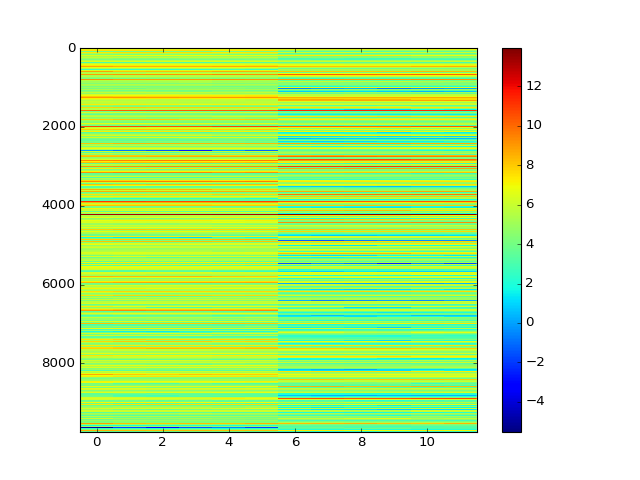

In [7]:
fig = plt.figure()
plt.imshow(D,interpolation = "none", aspect = "auto")
plt.colorbar()

## Example 1: 2 bioreps

In [8]:
print list(enumerate(header[4:]))

[(0, 'WT_unstim_rep1'), (1, 'WT_unstim_rep2'), (2, 'Ripk3_unstim_rep1'), (3, 'Ripk3_unstim_rep2'), (4, 'Ripk3Casp8_unstim_rep1'), (5, 'Ripk3Casp8_unstim_rep2'), (6, 'WT_LPS.6hr_rep1'), (7, 'WT_LPS.6hr_rep2'), (8, 'Ripk3_LPS.6hr_rep1'), (9, 'Ripk3_LPS.6hr_rep2'), (10, 'Ripk3Casp8_LPS.6hr_rep1'), (11, 'Ripk3Casp8_LPS.6hr_rep2')]


In [9]:
P = D[:,(6,7)]
P.shape

(9740, 2)

<IPython.core.display.Javascript object>


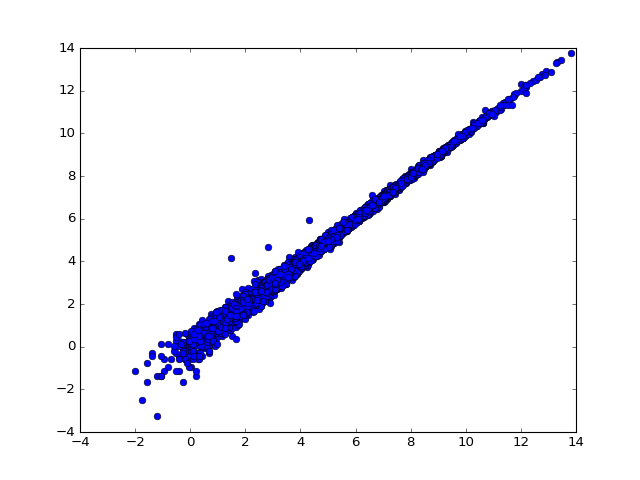

In [10]:
fig = plt.figure()
plt.plot(P[:,0],P[:,1],"bo")

<IPython.core.display.Javascript object>


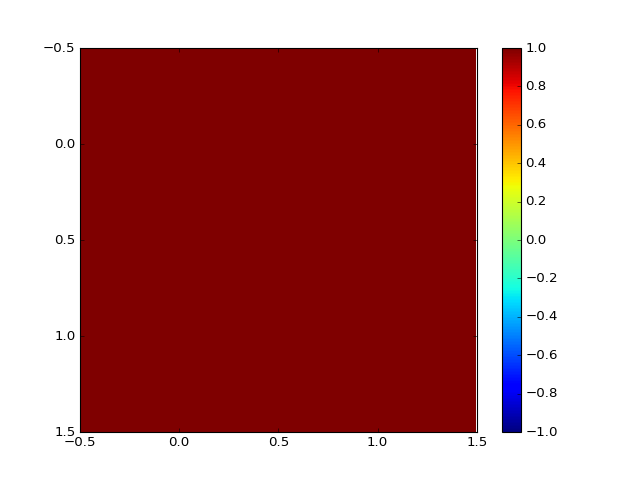

In [11]:
C = correlation_matrix(P.T)
fig = plt.figure()
plt.imshow(C, interpolation = "none", aspect = "auto", vmin=-1, vmax = 1)
plt.colorbar()

In [12]:
a = (P[:,0]+P[:,1])/2. # average
m = (P[:,1]-P[:,0])    # fold change

<IPython.core.display.Javascript object>


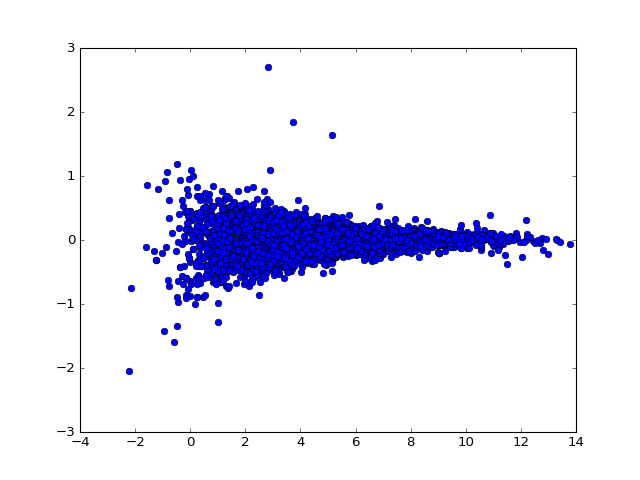

In [13]:
fig = plt.figure()
plt.plot(a,m,"bo")

What happens to the correlation matrix for the new coordinates?

In [14]:
AM = np.vstack((a,m)).T
AM.shape

(9740, 2)

<IPython.core.display.Javascript object>


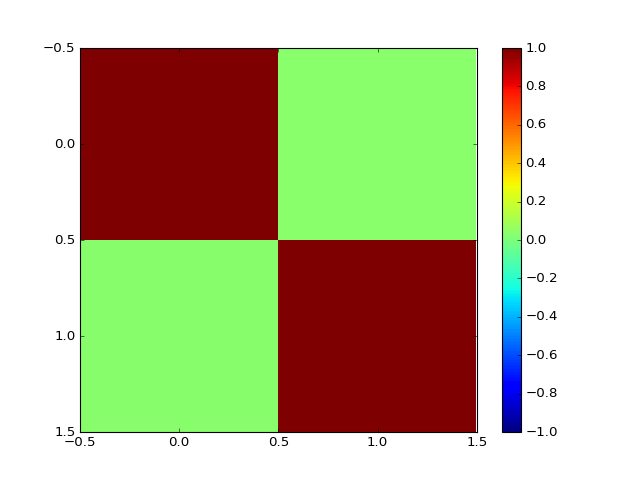

In [15]:
C = correlation_matrix(AM.T)
fig = plt.figure()
plt.imshow(C, interpolation = "none", aspect = "auto",vmin=-1, vmax = 1)
plt.colorbar()

So, we've factored the data into a correlated component, $a$, and an uncorrelated component, $m$.

Let's think about the transform we just applied:

$P \left( \begin{array}{cc}
\frac{1}{2} & -1 \\
\frac{1}{2}  & 1  \end{array} \right) =
\left( \begin{array}{cc}
a & m \end{array} \right)$

If we think of the columns as vectors, we can normalize them to give unit vectors (giving a scaled result):

$P \left( \begin{array}{cc}
\frac{1}{\sqrt{2}} & -\frac{1}{\sqrt{2}} \\
\frac{1}{\sqrt{2}}  & \frac{1}{\sqrt{2}} \end{array} \right) =
\left( \begin{array}{cc}
a \sqrt{2} & \frac{m}{\sqrt{2}} \end{array} \right) = 
\left( \begin{array}{cc}
a' & m' \end{array} \right)$

This has the form of a clockwise rotation about the origin by $\theta = \frac{\pi}{4}$:

$P \left( \begin{array}{cc}
\cos(\theta) & -\sin(\theta) \\
\sin(\theta)  & \cos(\theta) \end{array} \right) =
\left( \begin{array}{cc}
a' & m' \end{array} \right)$

Note that clockwise rotation of our data is equivalent to counterclockwise rotation of the axes.  In general, matrices giving such rigid body transforms are *orthogonal* matrices.

In fact, we can factor out the correlations of any square symetric matrix (*e.g.*, a correlation or covariance matrix) by a rotation about the origin, given by an orthogonal matrix.  The columns of the orthogonal matrix give the axes of the new coordinate system and are called *eigenvectors*.

Here's one way to calculate them using numpy:

In [16]:
(eigenvalues, eigenvectors) = np.linalg.eigh(correlation_matrix(P.T))
print eigenvectors
print eigenvalues

[[ 0.70710678 -0.70710678]
 [-0.70710678 -0.70710678]]
[ 0.00322129  1.99677871]


In [17]:
np.sqrt(1./2)

0.70710678118654757

A cheaper method, for the special case of matrices formed by the product of a rectangular matrix with its transpose, is singular value decomposition:

In [18]:
u,s,v = np.linalg.svd(scale(P).T, full_matrices=False)
print u
print s

[[-0.70767925 -0.70653385]
 [-0.70653385  0.70767925]]
[ 98.35858543   8.09868336]


Here is the relationship between the singular values and the eigenvalues

In [19]:
v = s**2
v/sum(v)

array([ 0.99326605,  0.00673395])

In [20]:
eigenvalues/sum(eigenvalues)

array([ 0.00161065,  0.99838935])

Note that, in this case, we get the same eigenvectors for diagonalization of the *covariance* matrix:

In [21]:
u,s,v = np.linalg.svd(center(P).T, full_matrices=False)
print u
print s

[[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
[  1.18914972e+01   4.21612629e-14]


This is convenient, because it conserves euclidean distances among our data

## Example 2: Single reps for LPS vs. the three genotypes

In [22]:
T = D[:,(6,8,10)]
T.shape

(9740, 3)

<IPython.core.display.Javascript object>


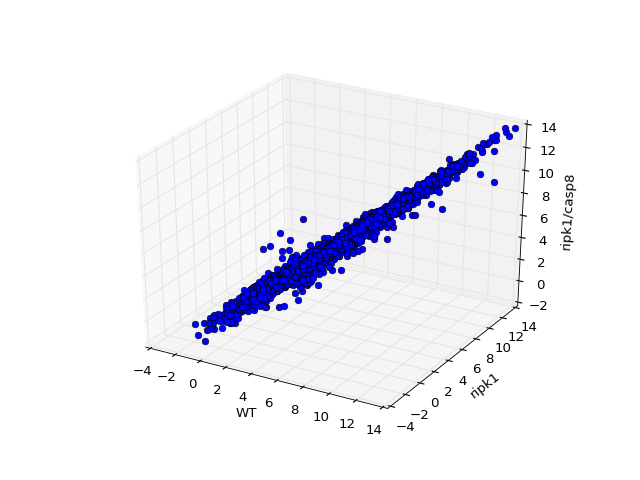

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(T[:,0],T[:,1],T[:,2],"bo")
ax.set_xlabel("WT")
ax.set_ylabel("ripk1")
ax.set_zlabel("ripk1/casp8")

<IPython.core.display.Javascript object>


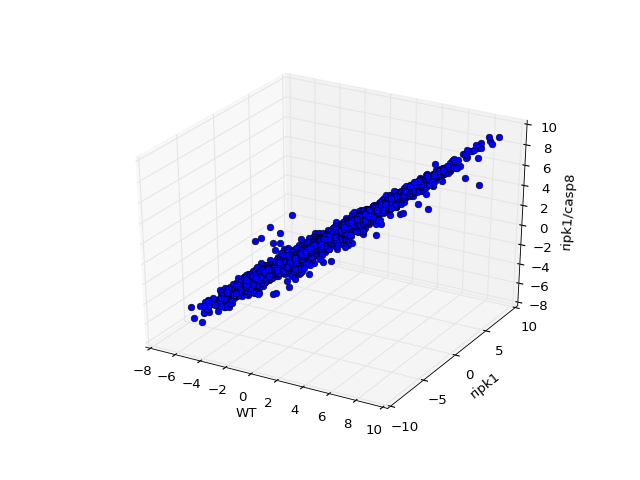

In [24]:
C = center2(T)
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(C[:,0],C[:,1],C[:,2],"bo")
ax.set_xlabel("WT")
ax.set_ylabel("ripk1")
ax.set_zlabel("ripk1/casp8")

In [25]:
u,s,v = np.linalg.svd(center2(T).T, full_matrices=False)
print u
print s

[[-0.58028312  0.34076001  0.73969867]
 [-0.58163209  0.46235508 -0.66927714]
 [-0.57006632 -0.81860271 -0.0700999 ]]
[ 359.17376481   25.43227689   17.39744127]


In [26]:
v = s**2
v/sum(v)

array([ 0.99269386,  0.0049771 ,  0.00232904])

In [27]:
projected = np.dot(center2(T),u)
projected.shape

(9740, 3)

<IPython.core.display.Javascript object>


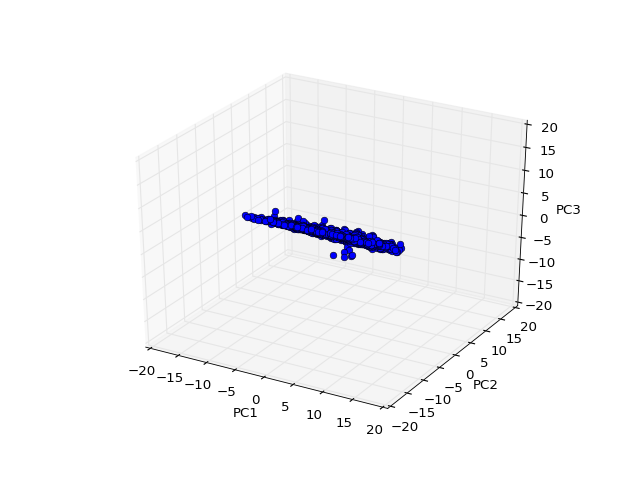

(-20.0, 20.0)

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(projected[:,0],projected[:,1],projected[:,2],"bo")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
L = 0
for i in (ax.get_xlim3d, ax.get_ylim3d, ax.get_zlim3d):
    (a,b) = i()
    L = max(L, -a, b)
ax.set_xlim3d(-L,L)
ax.set_ylim3d(-L,L)
ax.set_zlim3d(-L,L)

<IPython.core.display.Javascript object>


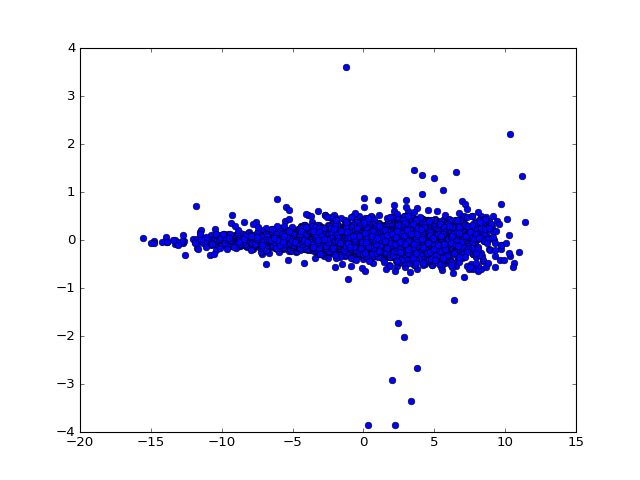

In [29]:
fig = plt.figure()
plt.plot(projected[:,0],projected[:,2],"bo")

## Example 3: full data

In [30]:
u,s,v = np.linalg.svd(center2(D).T, full_matrices=False)
print u
print s

[[-0.23314683 -0.33800765  0.0931839  -0.55675919  0.49682951 -0.43854053
   0.19779344 -0.02795928 -0.1263156   0.03987757  0.05329115 -0.11524854]
 [-0.23650365 -0.34507197  0.13897151 -0.2475999   0.05957928  0.36933152
  -0.66269901  0.06977104  0.20592913 -0.28674972  0.03242392  0.18626761]
 [-0.23672035 -0.34204139  0.12456591  0.35154124  0.11346939  0.33244105
   0.12571344 -0.04257587  0.03682087  0.05583463 -0.09514247 -0.73030059]
 [-0.23431407 -0.34641052  0.13123659  0.30340151  0.14157011  0.26350799
   0.46504383 -0.02236352 -0.07312219  0.05696346 -0.01821465  0.63297175]
 [-0.24101067 -0.2953888  -0.25532377  0.04654258 -0.50106544 -0.36758365
   0.14592464  0.00734587  0.08614788 -0.50919277 -0.33588095 -0.01599511]
 [-0.23913266 -0.32560949 -0.19903841  0.10350559 -0.38164531 -0.22089131
  -0.26282283  0.02325895 -0.13172716  0.619816    0.34589564  0.03512398]
 [-0.33313624  0.24385107  0.23035632 -0.31216116 -0.2605019   0.10657546
   0.15719409 -0.48933168  0.467

In [31]:
v = s**2
v/sum(v)

array([  8.24224067e-01,   1.67601443e-01,   2.81946653e-03,
         1.74313851e-03,   1.08885193e-03,   7.80716766e-04,
         4.31154111e-04,   3.30345943e-04,   3.04979295e-04,
         2.69126263e-04,   2.38794348e-04,   1.67916055e-04])

<IPython.core.display.Javascript object>


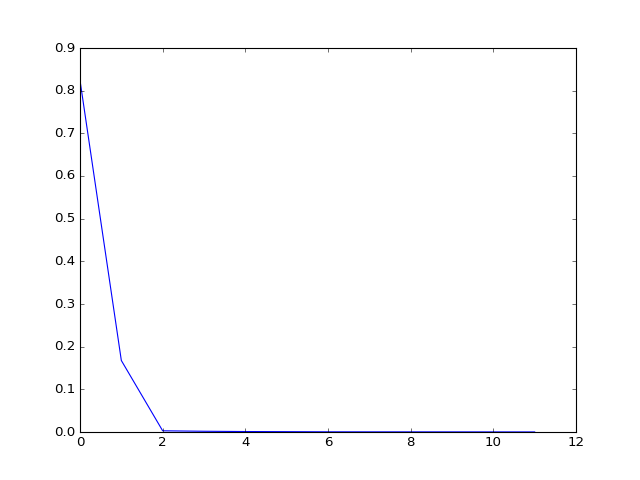

In [32]:
fig = plt.figure()
plt.plot(v/sum(v))

<IPython.core.display.Javascript object>


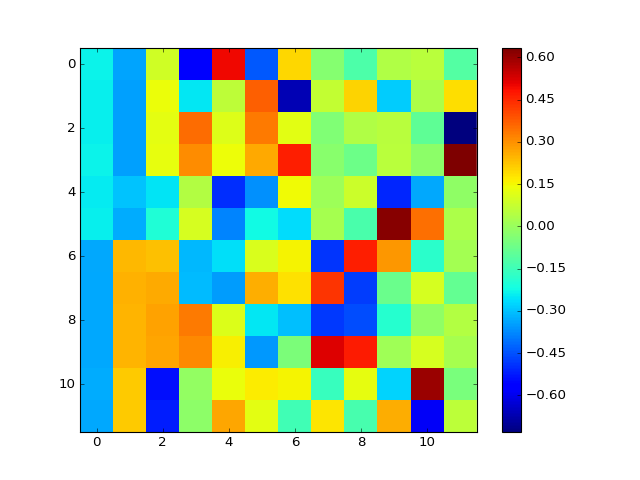

In [33]:
fig = plt.figure()
plt.imshow(u, interpolation = "none", aspect = "auto")
plt.colorbar()

In [34]:
projected = np.dot(center2(D),u)
projected.shape

(9740, 12)

<IPython.core.display.Javascript object>


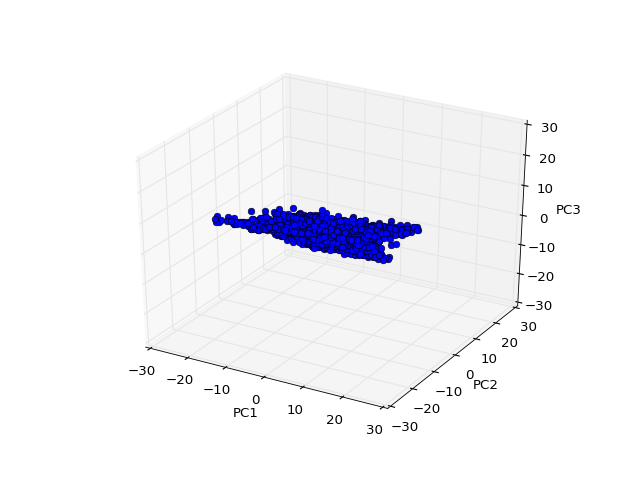

(-30.0, 30.0)

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(projected[:,0],projected[:,1],projected[:,2],"bo")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
L = 0
for i in (ax.get_xlim3d, ax.get_ylim3d, ax.get_zlim3d):
    (a,b) = i()
    L = max(L, -a, b)
ax.set_xlim3d(-L,L)
ax.set_ylim3d(-L,L)
ax.set_zlim3d(-L,L)

<IPython.core.display.Javascript object>


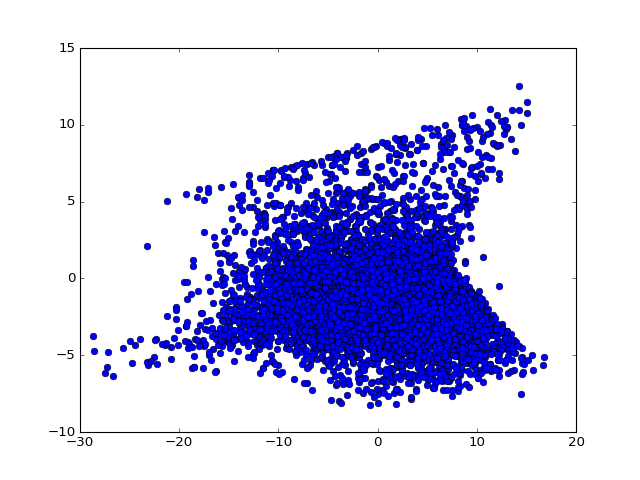

In [36]:
fig = plt.figure()
plt.plot(projected[:,0],projected[:,1],"bo")

### Dropping first component via row centering

In [37]:
u,s,v = np.linalg.svd(center2(center(D)).T, full_matrices=False)
print u
print s

[[-0.29620815  0.0948545  -0.55727961 -0.49498044 -0.44056855  0.18752953
  -0.03105885 -0.12419285  0.04802166  0.05366606  0.11628077  0.28867513]
 [-0.30001431  0.1365613  -0.24314944 -0.06415313  0.38180776 -0.65314894
   0.07792464  0.20015701 -0.3003035   0.03252459 -0.18712562  0.28867513]
 [-0.29715318  0.12148577  0.35438216 -0.11539136  0.33099238  0.12847804
  -0.04399742  0.03757991  0.05712874 -0.09513163  0.73005594  0.28867513]
 [-0.30281709  0.12940126  0.30468575 -0.1420074   0.25426808  0.46995714
  -0.02575526 -0.07119937  0.0615597  -0.01821969 -0.63234332  0.28867513]
 [-0.25246869 -0.25430785  0.04304819  0.50421048 -0.36969941  0.14566294
   0.0085859   0.0830444  -0.50543685 -0.3339152   0.01847096  0.28867513]
 [-0.28074926 -0.20055571  0.10359865  0.38174947 -0.20938377 -0.2775018
   0.02040999 -0.12683686  0.61984299  0.3438293  -0.03717128  0.28867513]
 [ 0.29537846  0.23068211 -0.31092719  0.25880012  0.11164816  0.14593503
  -0.49505415  0.46866499  0.2827

In [38]:
v = s**2
v/sum(v)

array([  9.57724127e-01,   1.45637973e-02,   9.00395880e-03,
         5.61893353e-03,   4.06731496e-03,   2.25011304e-03,
         1.70485686e-03,   1.57348463e-03,   1.39517522e-03,
         1.23176615e-03,   8.66472553e-04,   4.58123957e-31])

<IPython.core.display.Javascript object>


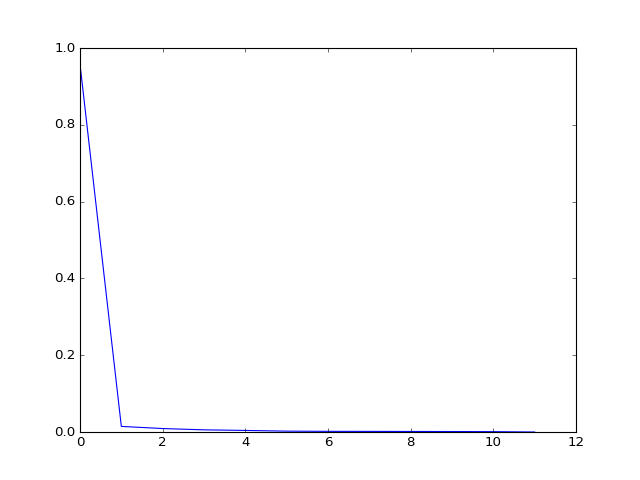

In [39]:
fig = plt.figure()
plt.plot(v/sum(v))

<IPython.core.display.Javascript object>


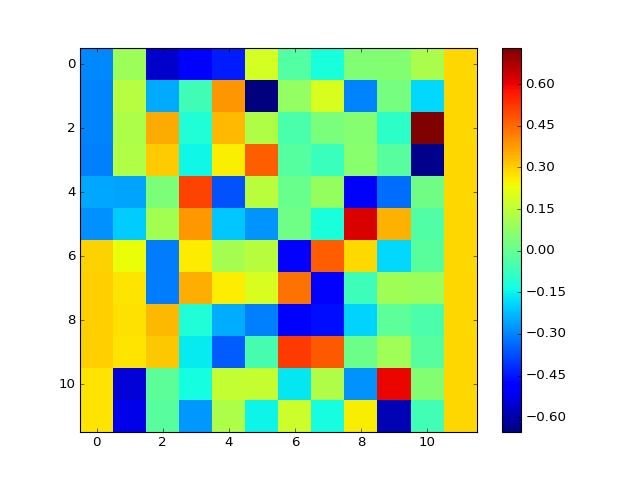

In [40]:
fig = plt.figure()
plt.imshow(u, interpolation = "none", aspect = "auto")
plt.colorbar()

In [41]:
projected = np.dot(center2(center(D)),u)
projected.shape

(9740, 12)

<IPython.core.display.Javascript object>


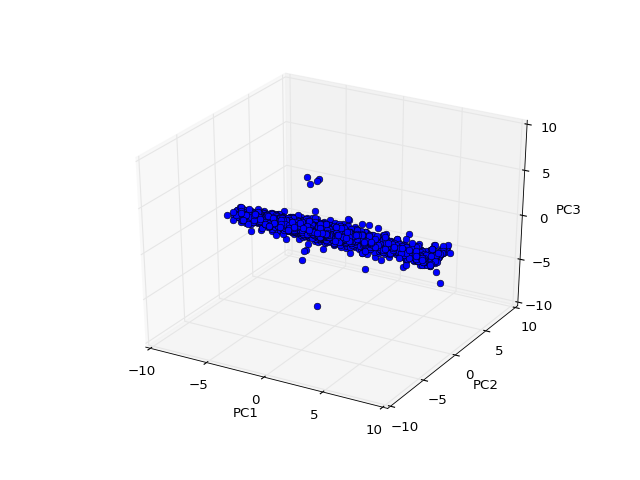

(-10.0, 10.0)

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(projected[:,0],projected[:,1],projected[:,2],"bo")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
L = 0
for i in (ax.get_xlim3d, ax.get_ylim3d, ax.get_zlim3d):
    (a,b) = i()
    L = max(L, -a, b)
ax.set_xlim3d(-L,L)
ax.set_ylim3d(-L,L)
ax.set_zlim3d(-L,L)

<IPython.core.display.Javascript object>


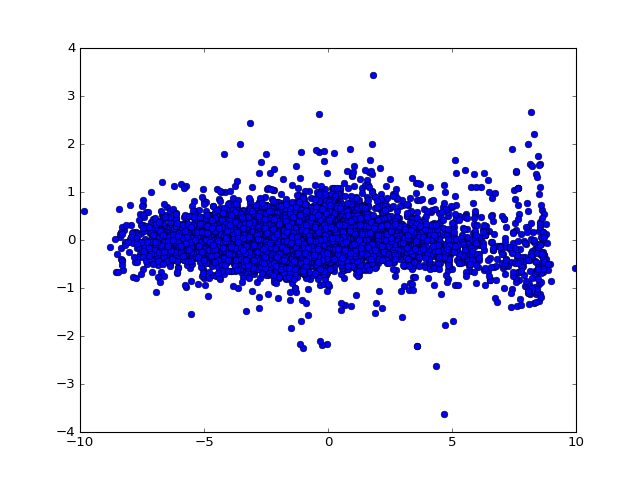

In [43]:
fig = plt.figure()
plt.plot(projected[:,0],projected[:,1],"bo")

In [44]:
IL6 = projected[Da[:,0] == "ENSMUSG00000025746"]
IL6

array([[  8.62656137e+00,   6.31460703e-01,   7.31625997e-02,
          4.94740279e-01,  -5.05907061e-01,   8.46856998e-02,
         -1.32246106e-01,   8.38078139e-02,  -3.43614489e-01,
         -1.42566194e-01,  -1.34092386e-02,  -3.48094379e-15]])

<IPython.core.display.Javascript object>


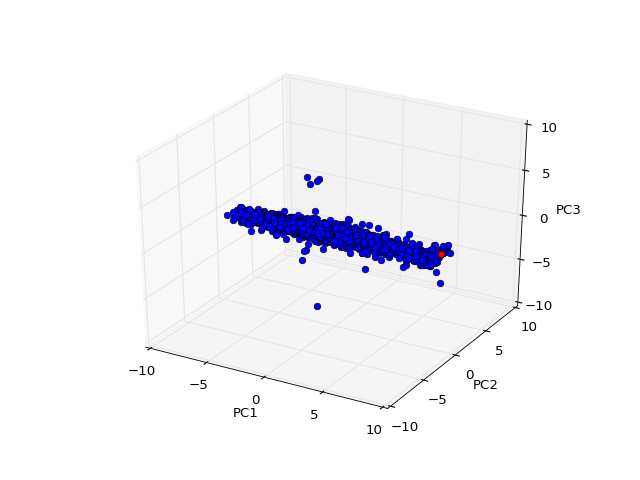

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(projected[:,0],projected[:,1],projected[:,2],"bo")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
L = 0
for i in (ax.get_xlim3d, ax.get_ylim3d, ax.get_zlim3d):
    (a,b) = i()
    L = max(L, -a, b)
ax.set_xlim3d(-L,L)
ax.set_ylim3d(-L,L)
ax.set_zlim3d(-L,L)

ax.plot(IL6[:,0],IL6[:,1],IL6[:,2],"ro")

In [46]:
print Da[np.logical_and(projected[:,0] > 8,projected[:,1] > .5),:]

[['ENSMUSG00000004296' '16160' 'interleukin 12b' 'Il12b']
 ['ENSMUSG00000015316' '27218'
  'signaling lymphocytic activation molecule family member 1' 'Slamf1']
 ['ENSMUSG00000023903' '240047' 'matrix metallopeptidase 25' 'Mmp25']
 ['ENSMUSG00000025746' '16193' 'interleukin 6' 'Il6']
 ['ENSMUSG00000026822' '16819' 'lipocalin 2' 'Lcn2']
 ['ENSMUSG00000026981' '16181' 'interleukin 1 receptor antagonist' 'Il1rn']
 ['ENSMUSG00000027398' '16176' 'interleukin 1 beta' 'Il1b']
 ['ENSMUSG00000027399' '16175' 'interleukin 1 alpha' 'Il1a']
 ['ENSMUSG00000027776' '16159' 'interleukin 12a' 'Il12a']
 ['ENSMUSG00000029275' '14581' 'growth factor independent 1' 'Gfi1']
 ['ENSMUSG00000029379' '330122' 'chemokine (C-X-C motif) ligand 3' 'Cxcl3']
 ['ENSMUSG00000031779' '20299' 'chemokine (C-C motif) ligand 22' 'Ccl22']
 ['ENSMUSG00000031780' '20295' 'chemokine (C-C motif) ligand 17' 'Ccl17']
 ['ENSMUSG00000032487' '19225' 'prostaglandin-endoperoxide synthase 2'
  'Ptgs2']
 ['ENSMUSG00000037411' '18787'
 

### Plotting samples in gene space

In [47]:
u,s,v = np.linalg.svd(center(D), full_matrices=False)
print u
print s

[[-0.00133721  0.00480044 -0.00270164 ..., -0.00075354  0.00293899
   0.04462168]
 [-0.01798582 -0.00054118 -0.00701113 ..., -0.00757694 -0.00325514
  -0.05301202]
 [-0.01561022  0.00323661 -0.00526793 ..., -0.01364715  0.0037156
   0.0291402 ]
 ..., 
 [ 0.0055479   0.0135659   0.00861415 ...,  0.01741676 -0.00446377
   0.00088564]
 [-0.00329741 -0.00783214  0.00191798 ..., -0.01128709  0.00370093
  -0.00247501]
 [-0.00517008 -0.00175469 -0.00532058 ...,  0.00190347 -0.0016609
   0.01786938]]
[  2.85078574e+02   3.51545608e+01   2.76414686e+01   2.18359107e+01
   1.85779703e+01   1.38180427e+01   1.20278589e+01   1.15551507e+01
   1.08807477e+01   1.02237094e+01   8.57475595e+00   1.97167614e-13]


In [48]:
v = s**2
v/sum(v)

array([  9.57724127e-01,   1.45637973e-02,   9.00395880e-03,
         5.61893353e-03,   4.06731496e-03,   2.25011304e-03,
         1.70485686e-03,   1.57348463e-03,   1.39517522e-03,
         1.23176615e-03,   8.66472553e-04,   4.58123357e-31])

<IPython.core.display.Javascript object>


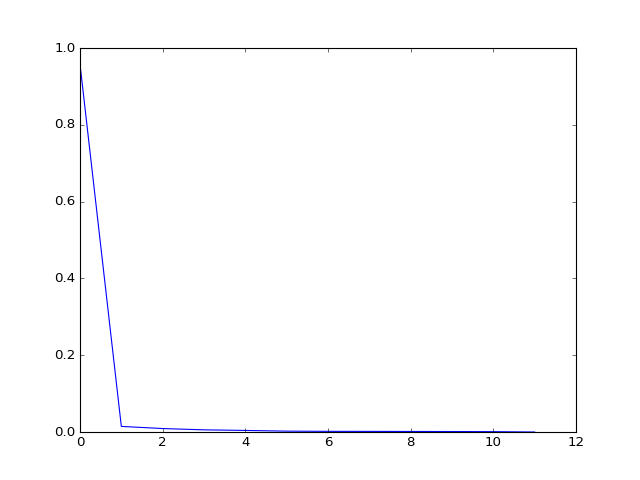

In [49]:
fig = plt.figure()
plt.plot(v/sum(v))

In [50]:
projected = np.dot(center(D).T,u)
projected.shape

(12, 12)

<IPython.core.display.Javascript object>


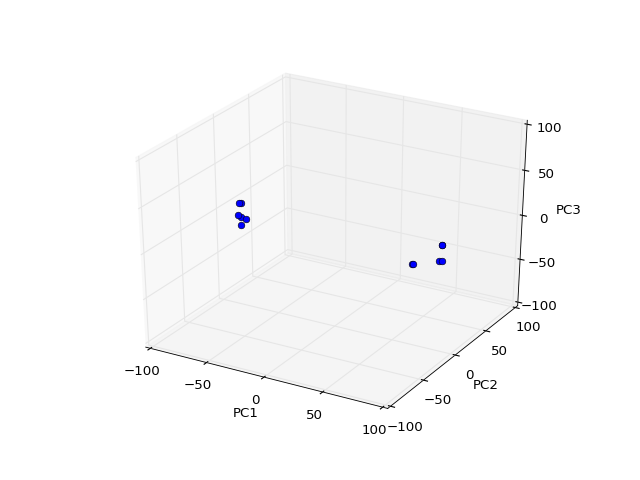

(-100.0, 100.0)

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(projected[:,0],projected[:,1],projected[:,2],"bo")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
L = 0
for i in (ax.get_xlim3d, ax.get_ylim3d, ax.get_zlim3d):
    (a,b) = i()
    L = max(L, -a, b)
ax.set_xlim3d(-L,L)
ax.set_ylim3d(-L,L)
ax.set_zlim3d(-L,L)

In [52]:
highlights = {}

for i in header[4:]:
    if(i.startswith("WT")):
        color = "black"
    elif(i.startswith("Ripk3Casp8")):
        color = "orange"
    else:
        color = "green"
    
    if(i.find("LPS") > -1):
        marker = "o"
    else:
        marker = "^"
    
    highlights[i] = (color,marker)
    
highlights

{'Ripk3Casp8_LPS.6hr_rep1': ('orange', 'o'),
 'Ripk3Casp8_LPS.6hr_rep2': ('orange', 'o'),
 'Ripk3Casp8_unstim_rep1': ('orange', '^'),
 'Ripk3Casp8_unstim_rep2': ('orange', '^'),
 'Ripk3_LPS.6hr_rep1': ('green', 'o'),
 'Ripk3_LPS.6hr_rep2': ('green', 'o'),
 'Ripk3_unstim_rep1': ('green', '^'),
 'Ripk3_unstim_rep2': ('green', '^'),
 'WT_LPS.6hr_rep1': ('black', 'o'),
 'WT_LPS.6hr_rep2': ('black', 'o'),
 'WT_unstim_rep1': ('black', '^'),
 'WT_unstim_rep2': ('black', '^')}

/home/bms270/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


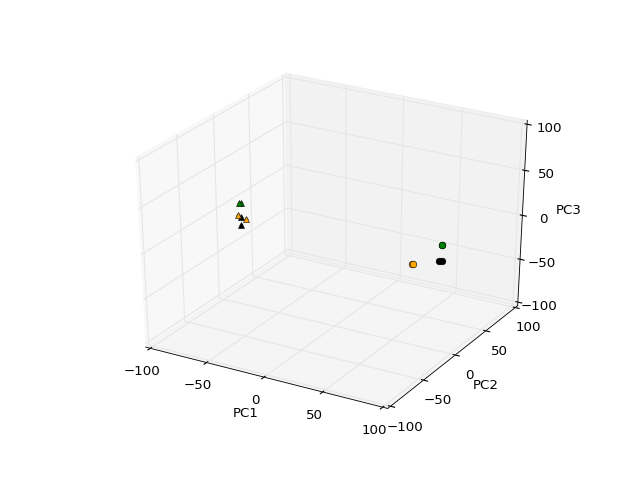

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(projected[:,0],projected[:,1],projected[:,2],marker = ".", color = "gray", linestyle="none")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
L = 0
for i in (ax.get_xlim3d, ax.get_ylim3d, ax.get_zlim3d):
    (a,b) = i()
    L = max(L, -a, b)
ax.set_xlim3d(-L,L)
ax.set_ylim3d(-L,L)
ax.set_zlim3d(-L,L)

for (n, name) in enumerate(header[4:]):
    (color, marker) = highlights[name]
    ax.plot([projected[n,0]],[projected[n,1]],[projected[n,2]],marker = marker, color = color, linestyle = "none")